# Evasion

> Attacks against classification models that construct special inputs (a.k.a AEs- adversarial examples) that appear natural to a human but are misclassified by the model

In [ ]:
#| default_exp evasion

In [ ]:
#| hide
from nbdev.showdoc import *

While other implementations of AE attacks exist, this one is meant to be as easy, accessible, informative and modular as training model. In fact, this implementation uses `fastai`'s `Learner` class, and inherits its functionality, such as the progress bar, the losses table, and even early stopping and lr scheduling.

## API

In [ ]:
#| export
from abc import abstractmethod

import torch
from torch import nn
from fastai.vision.all import *

from adv_ml.input_optimization import *


class PGDCallback(PerturbationCallback):
    "Implementes Projected Gradient Descent by bounding some $l_p$ norm of the perturbation"
    def __init__(self, epsilon=.3, rand_init=True):
        super().__init__()
        self.epsilon = epsilon
        self.p = nn.Parameter()

    def init_pert(self, x):
        self.p.data = self.rand_init(x.shape) if self.rand_init else torch.zeros(x.shape)
        self.clamp_pixel_values(x)
    
    def clamp_pixel_values(self, x):
        "Clamp peturbation such that perturbing `x` maintains valid pixel values"
        with torch.no_grad():
            x = x.to(self.p.device)
            self.p.data = (x + self.p).clamp(0., 1.) - x 

    def suggest_lr(self, input_opt: InputOptimizer):
        return self.epsilon / input_opt.epoch_size

    def before_step(self):
        with torch.no_grad():
            self.steepest_descent()

    def after_batch(self):
        with torch.no_grad():
            self.project_pert()
            self.clamp_pixel_values(self.x)

In [ ]:
#| export
@patch()
@abstractmethod
def rand_init(self: PGDCallback, shape) -> Tensor:
    "Initialize a random perturbation in the $\epsilon$-ball"
    ...

In [ ]:
#| export
@patch
@abstractmethod
def steepest_descent(self: PGDCallback) -> None:
    "Edit the perturbation's gradient to implement steepest descent"
    ...

In [ ]:
#| export
@patch
@abstractmethod
def project_pert(self: PGDCallback) -> None:
    "Project the perturbation to the $\epsilon$-ball"
    ...

In order to demonstrate the attacks, let's first setup training data and an accurate classifier:

In [ ]:
from similarity_learning.all import *

In [ ]:
mnist = MNIST()
classifier = MLP(10)
learn = Learner(mnist.dls(), classifier, metrics=accuracy)
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,accuracy,time
0,0.105063,0.093810,0.971000,00:18


In [ ]:
sub_dsets = mnist.valid.random_sub_dsets(64)

In [ ]:
acc = learn.validate(dl=sub_dsets.dl())[1]
test(acc, .9, ge)

For reference, here is what the original input look like:

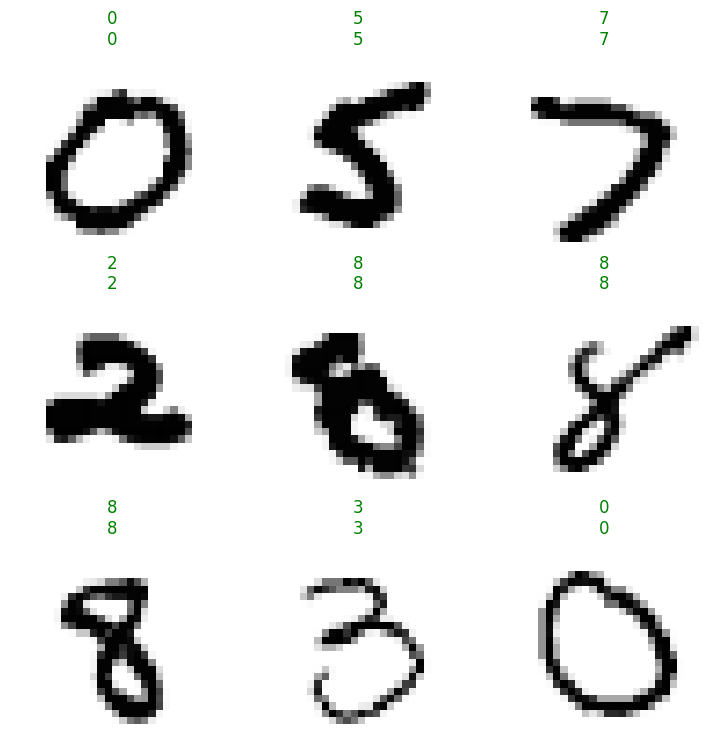

In [ ]:
learn.show_results(shuffle=False, dl=sub_dsets.dl())

This is enough for an untargeted attack, where we want to make AEs that the classifier misclassifies.
In a targeted attack, we require the AEs to be classified as specific classes. To demonstrate that, we'll construct a version of the data with random labels:

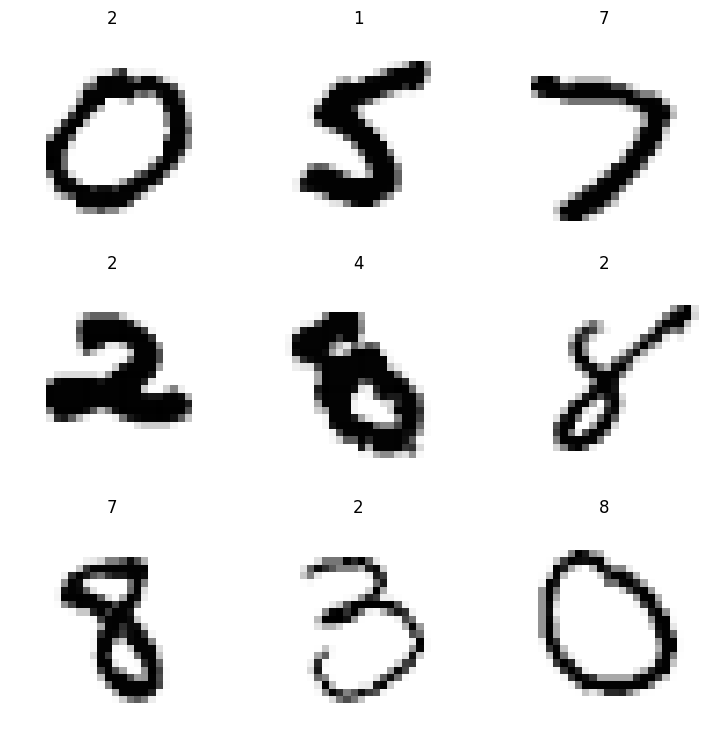

In [ ]:
item2target = {item: str(random.choice(range(10))) for item in sub_dsets.items}
random_targets = TfmdLists(sub_dsets.items, [item2target.__getitem__, Categorize()])
random_targets_dsets = Datasets(tls=[sub_dsets.tls[0], random_targets])
random_targets_dsets.dl().show_batch()

Since a targeted attack adds an additional requirement from the perturbation, we should use a bigger epsilon and more iterations.

## $l_\infty$ Norm

In [ ]:
#| export
class LinfPGD(PGDCallback):
    "Implements PGD by bounding the $l_\infty$ norm"
    def rand_init(self, shape):
        return torch.rand(shape) * self.epsilon

    def steepest_descent(self):
        self.p.grad.sign_()

    def project_pert(self):
        self.p.clamp_(-self.epsilon, self.epsilon)

### Untargeted

In [ ]:
attack = InputOptimizer(classifier, LinfPGD(epsilon=.15), n_epochs=10, epoch_size=20)
perturbed_dsets = attack.perturb(sub_dsets)

epoch,train_loss,time
0,-3.317830,00:00
1,-6.035948,00:00
2,-7.208374,00:00
3,-7.782593,00:00
4,-8.100239,00:00
5,-8.288338,00:00
6,-8.405439,00:00
7,-8.480438,00:00
8,-8.529491,00:00
9,-8.561683,00:00


In [ ]:
acc = learn.validate(dl=TfmdDL(perturbed_dsets))[1]
test(acc, .1, le)

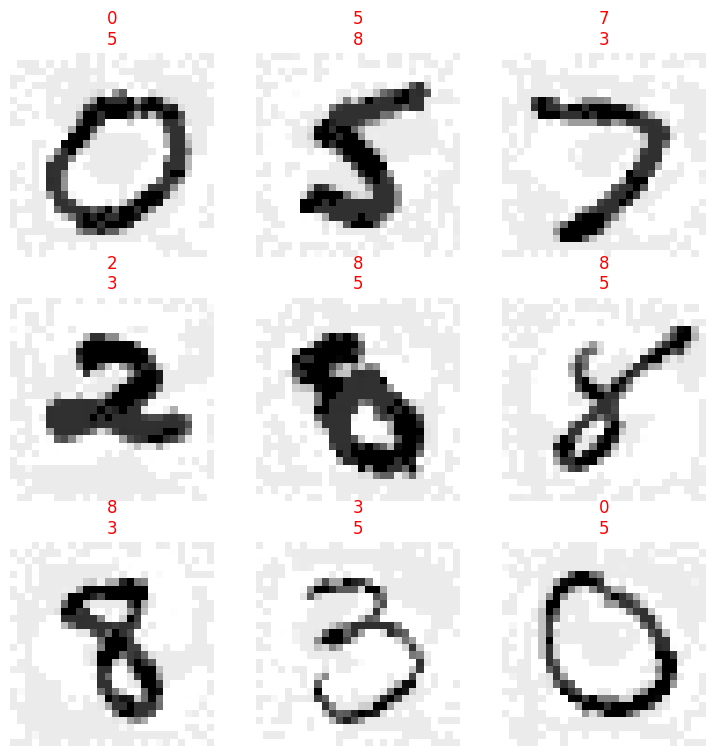

In [ ]:
learn.show_results(shuffle=False, dl=TfmdDL(perturbed_dsets))

### Targeted

In [ ]:
attack = InputOptimizer(classifier, LinfPGD(epsilon=.2), targeted=True, n_epochs=10, epoch_size=30)
perturbed_dsets = attack.perturb(random_targets_dsets)

epoch,train_loss,time
0,2.587283,00:00
1,1.211362,00:00
2,0.713616,00:00
3,0.493275,00:00
4,0.380555,00:00
5,0.316781,00:00
6,0.281744,00:00
7,0.262587,00:00
8,0.252041,00:00
9,0.246094,00:00


In [ ]:
acc = learn.validate(dl=TfmdDL(perturbed_dsets))[1]
test(acc, .9, ge)

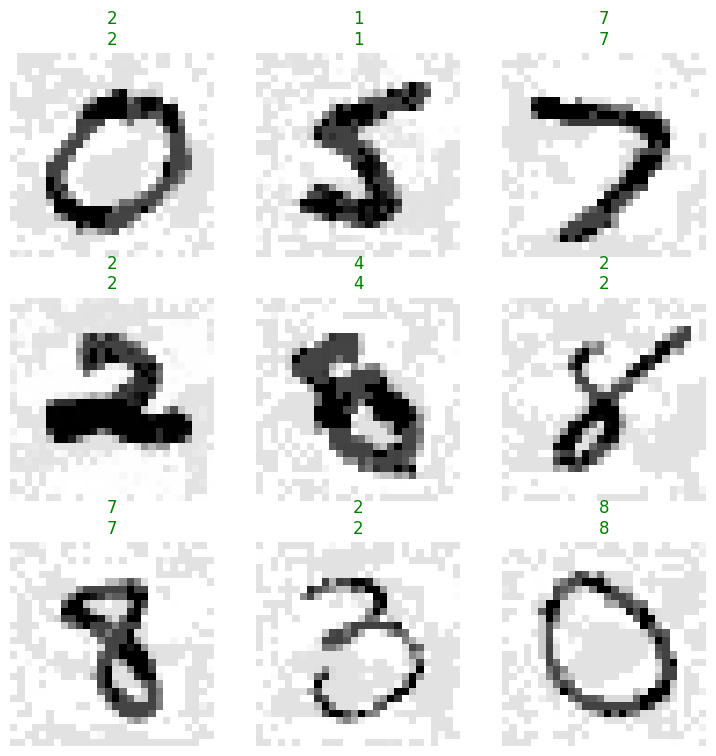

In [ ]:
learn.show_results(shuffle=False, dl=TfmdDL(perturbed_dsets))

## $l_2$ Norm

In [ ]:
#| export
import torch.nn.functional as F
from torch.linalg import vector_norm


@delegates(F.normalize)
def _batch_normalize(t, **kwargs):
    return F.normalize(t.view(t.shape[0], -1), **kwargs).view(*t.shape)


@delegates(_batch_normalize)
def _random_unit_vector(shape, **kwargs):
    return _batch_normalize(torch.randn(shape), **kwargs)


def _batch_norm(t, **kwargs):
    return vector_norm(t.view(t.size(0), -1), **kwargs)


class L2PGD(PGDCallback):
    "Implements PGD by bounding the $l_2$ norm"
    def rand_init(self, shape):
        rand_dir = _random_unit_vector(shape)
        rand_len = torch.rand(1) * self.epsilon
        return rand_dir * rand_len

    def steepest_descent(self):
        self.p.grad.data = _batch_normalize(self.p.grad)

    def project_pert(self):
        norm = _batch_norm(self.p)
        self.p.mul_(torch.min(self.epsilon/norm, torch.ones_like(norm)))

### Untargeted

Note that the $l_2$ norm can be up to $\sqrt{d}$ bigger than the $l_\infty$ norm, where $d$ is the dimension, so we need to use a bigger epsilon to obtain similar results:

In [ ]:
attack = InputOptimizer(classifier, L2PGD(epsilon=15), n_epochs=10)
perturbed_dsets = attack.perturb(sub_dsets)

epoch,train_loss,time
0,-3.854619,00:00
1,-4.788039,00:00
2,-5.098700,00:00
3,-5.251333,00:00
4,-5.340628,00:00
5,-5.398513,00:00
6,-5.437977,00:00
7,-5.466318,00:00
8,-5.487265,00:00
9,-5.503058,00:00


In [ ]:
acc = learn.validate(dl=TfmdDL(perturbed_dsets))[1]
test(acc, .1, le)

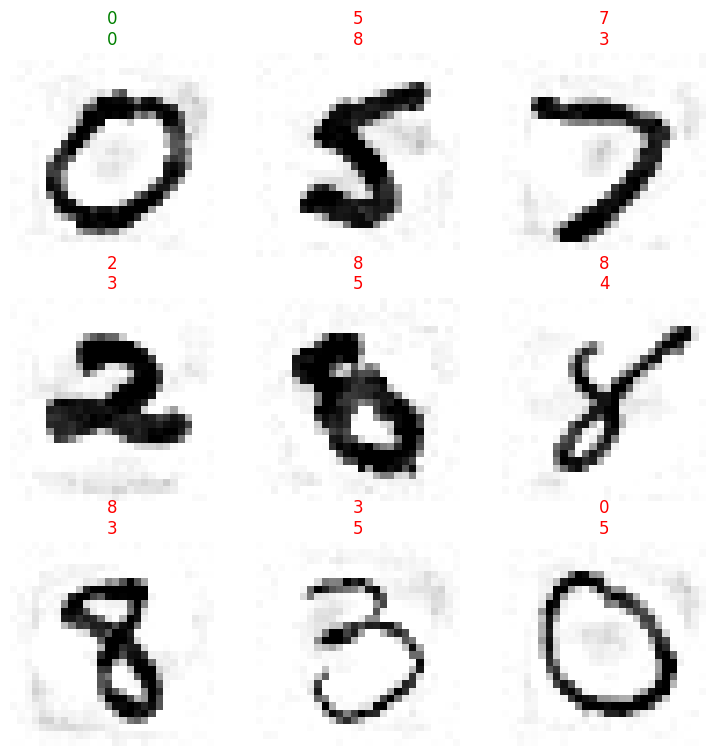

In [ ]:
learn.show_results(shuffle=False, dl=TfmdDL(perturbed_dsets))

### Targeted

In [ ]:
attack = InputOptimizer(classifier, L2PGD(epsilon=25), targeted=True, n_epochs=10, epoch_size=20,)
perturbed_dsets = attack.perturb(random_targets_dsets)

epoch,train_loss,time
0,1.122446,00:00
1,0.638857,00:00
2,0.481712,00:00
3,0.408478,00:00
4,0.367309,00:00
5,0.339710,00:00
6,0.323739,00:00
7,0.314110,00:00
8,0.276853,00:00
9,0.240247,00:00


In [ ]:
acc = learn.validate(dl=TfmdDL(perturbed_dsets))[1]
test(acc, .9, ge)

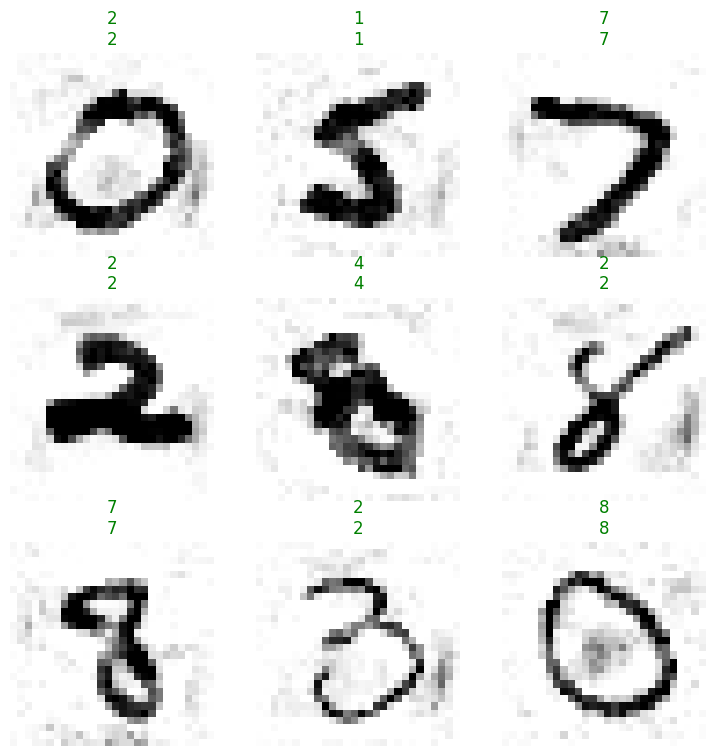

In [ ]:
learn.show_results(shuffle=False, dl=TfmdDL(perturbed_dsets))

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()